## Central-sat distribution in HOD:

Mass integral: 4838396571321.910 (should be ~1 after normalization)


/tmp/ipykernel_1428810/1273236943.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mass_check = 4 * np.pi * np.trapz(rho_r * r**2, r)


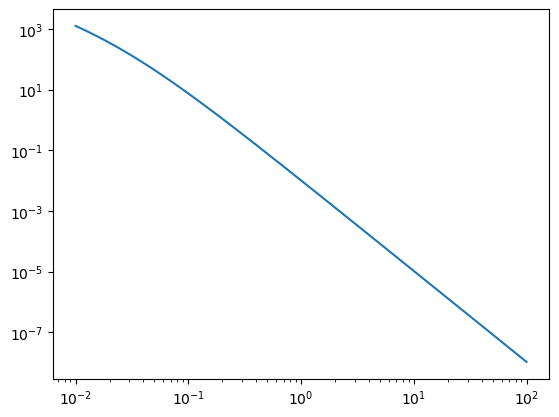

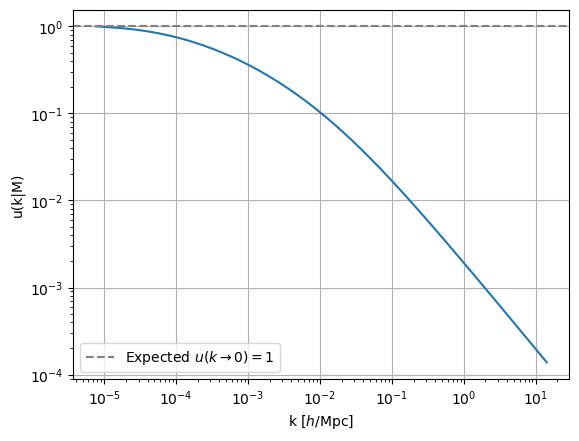

In [2]:
import numpy as np
from mcfit import Hankel
from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.utils import constants
from colossus.halo import profile_nfw
import matplotlib.pyplot as plt


def get_rpho_norm_colossus():
    cosmology.setCosmology('planck15')
    mass = 1e12  # Msun/h
    z = 0.0
    cvir = concentration.concentration(M=mass, z=z, mdef='vir', model='diemer19')
    p_nfw = profile_nfw.NFWProfile(M=mass, c=cvir, z=z, mdef='vir')

    r = np.logspace(-2, 2, 200)  # in Mpc/h
    rho_r = p_nfw.density(r * 1e3) * 1e9  # convert from kpc/h to Mpc/h

    mass_check = 4 * np.pi * np.trapz(rho_r * r**2, r)
    print(f"Mass integral: {mass_check:.3f} (should be ~1 after normalization)")
    rho_norm = rho_r / mass_check

    fig, ax = plt.subplots()
    ax.plot(r, rho_norm)
    ax.set_xscale('log')
    ax.set_yscale('log')
    return r, rho_norm

def get_uk():
    r, rho_norm = get_rpho_norm_colossus()
    f_r = 4 * np.pi * r**2 * rho_norm
    h = Hankel(r, lowring=True)
    uk, k = h(f_r, extrap=True)
    ind = np.where(k > 1e-20)
    k = k[ind]
    uk = uk[ind]
    return k, uk

k, uk = get_uk()
fig, ax = plt.subplots()
ax.loglog(k, np.abs(uk)/uk[-1])
ax.axhline(1, ls='--', color='gray', label='Expected $u(k\\to0)=1$')
ax.set_xlabel("k [$h$/Mpc]")
ax.set_ylabel("u(k|M)")
ax.grid(True)
ax.legend()


mass: 1.000e+07, cvir: 27.478, rvir: 4.380 (Mpc/h)
mass: 1.000e+11, cvir: 13.722, rvir: 94.368 (Mpc/h)
mass: 1.000e+12, cvir: 10.759, rvir: 203.311 (Mpc/h)


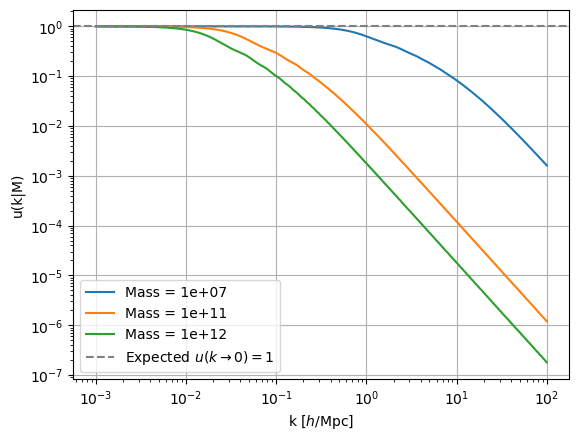

In [30]:
import numpy as np
from scipy import special
from colossus.halo import mass_defs

def compute_analytic_uk(mass, z):
    def analytic_uk(k, c, rvir):
        rs = rvir / c
        eta = k * rs
        f = 1.0 / (np.log(1 + c) - c / (1 + c))

        si_1pc, ci_1pc = special.sici((1 + c) * eta)
        si, ci = special.sici(eta)

        uk = f * (
            np.sin(eta) * (si_1pc - si) +
            np.cos(eta) * (ci_1pc - ci) -
            np.sin(c * eta) / ((1 + c) * eta)
        )

        return uk

    
    cvir = concentration.concentration(M=mass, z=z, mdef='vir', model='diemer19')
    _, rvir, _ = mass_defs.changeMassDefinition(mass, cvir, z=z, mdef_in='vir', mdef_out='vir')
    print(f"mass: {mass:.3e}, cvir: {cvir:.3f}, rvir: {rvir:.3f} (Mpc/h)")
    k = np.logspace(-3, 2, 1000)
    uk = analytic_uk(k, cvir, rvir)
    return k, uk


cosmology.setCosmology('planck15')
# Define masses to iterate over
masses = [1e7, 1e11, 1e12]

# Iterate over masses and compute/plot for each
fig, ax = plt.subplots()
for mass in masses:
    k_mass, uk_mass = compute_analytic_uk(mass=mass, z=0.0)
    ax.loglog(k_mass, np.abs(uk_mass), label=f'Mass = {mass:.0e}')

# Add labels, grid, and legend
ax.axhline(1, ls='--', color='gray', label='Expected $u(k\\to0)=1$')
ax.set_xlabel("k [$h$/Mpc]")
ax.set_ylabel("u(k|M)")
ax.grid(True)
ax.legend()



mass: 3.000e+11, cvir: 11.909, rvir: 136.103 (Mpc/h)
mass: 3.000e+11, cvir: 12.342, rvir: 136.103 (Mpc/h)
mass: 3.000e+11, cvir: 13.024, rvir: 136.103 (Mpc/h)


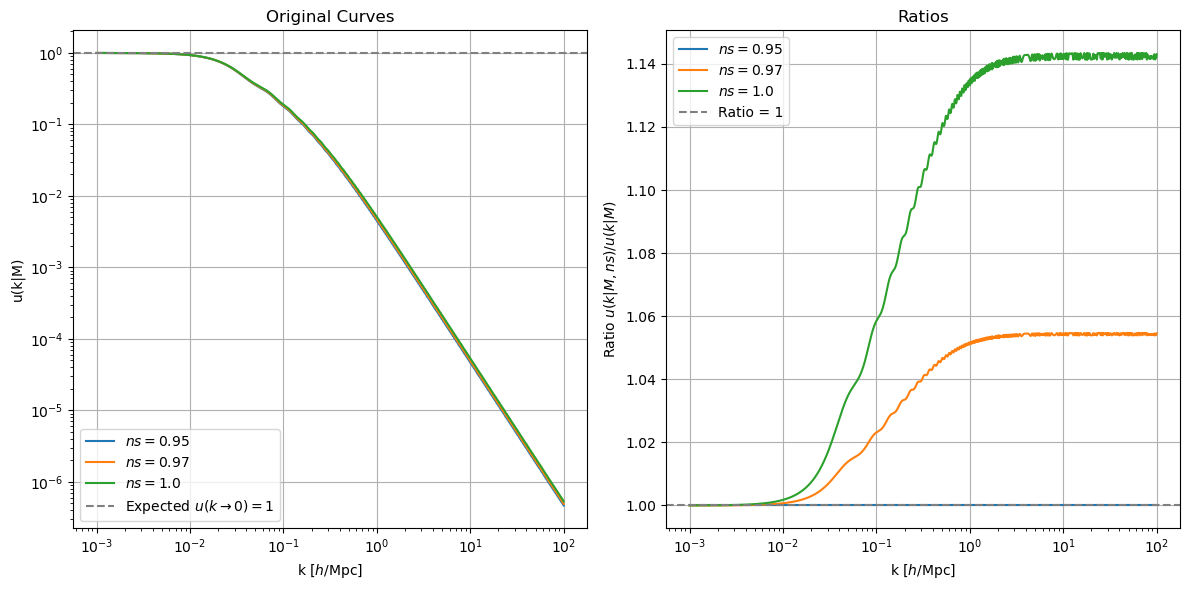

mass: 3.000e+11, cvir: 10.301, rvir: 136.103 (Mpc/h)
mass: 3.000e+11, cvir: 11.994, rvir: 136.103 (Mpc/h)
mass: 3.000e+11, cvir: 13.742, rvir: 136.103 (Mpc/h)


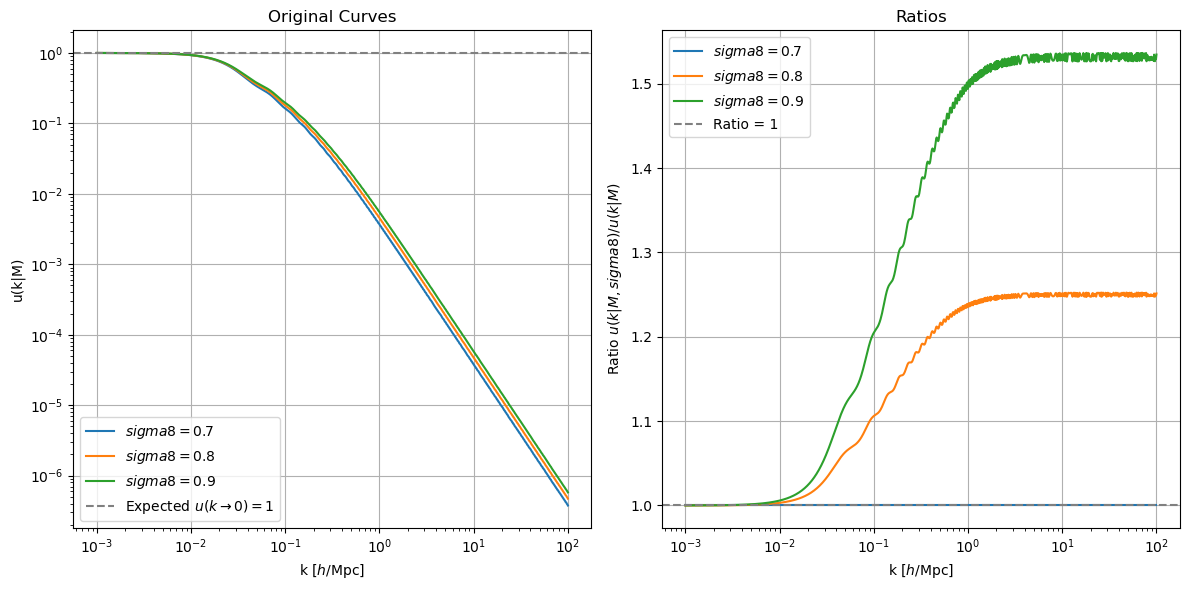

mass: 3.000e+11, cvir: 12.211, rvir: 136.103 (Mpc/h)
mass: 3.000e+11, cvir: 12.445, rvir: 136.103 (Mpc/h)
mass: 3.000e+11, cvir: 12.675, rvir: 136.103 (Mpc/h)


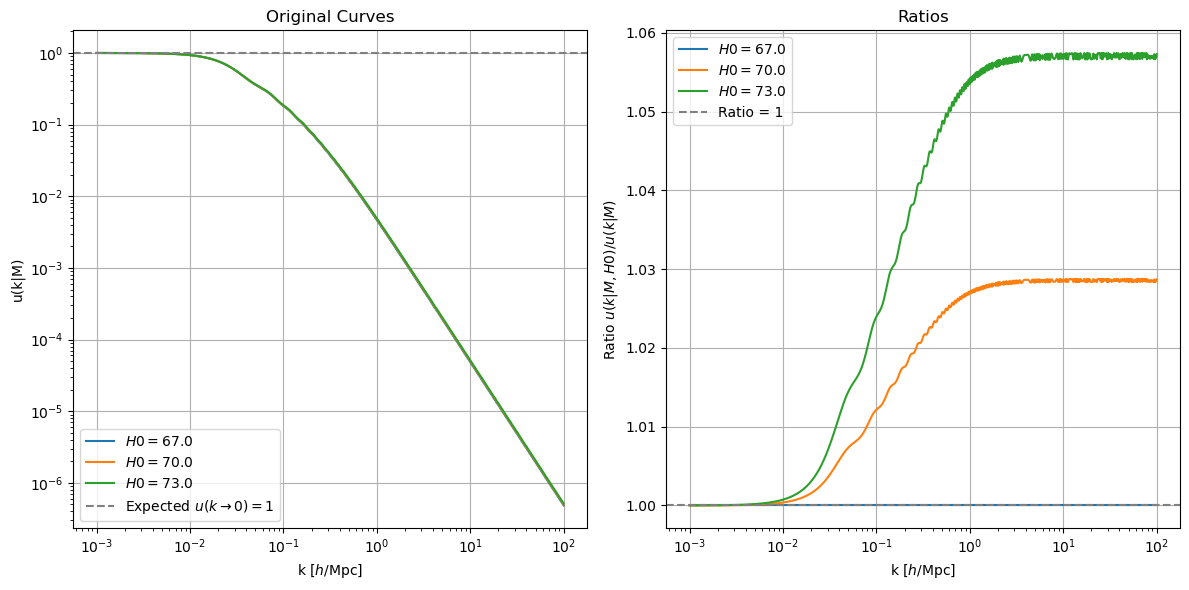

mass: 3.000e+11, cvir: 10.950, rvir: 139.915 (Mpc/h)
mass: 3.000e+11, cvir: 12.072, rvir: 136.645 (Mpc/h)
mass: 3.000e+11, cvir: 13.173, rvir: 133.741 (Mpc/h)


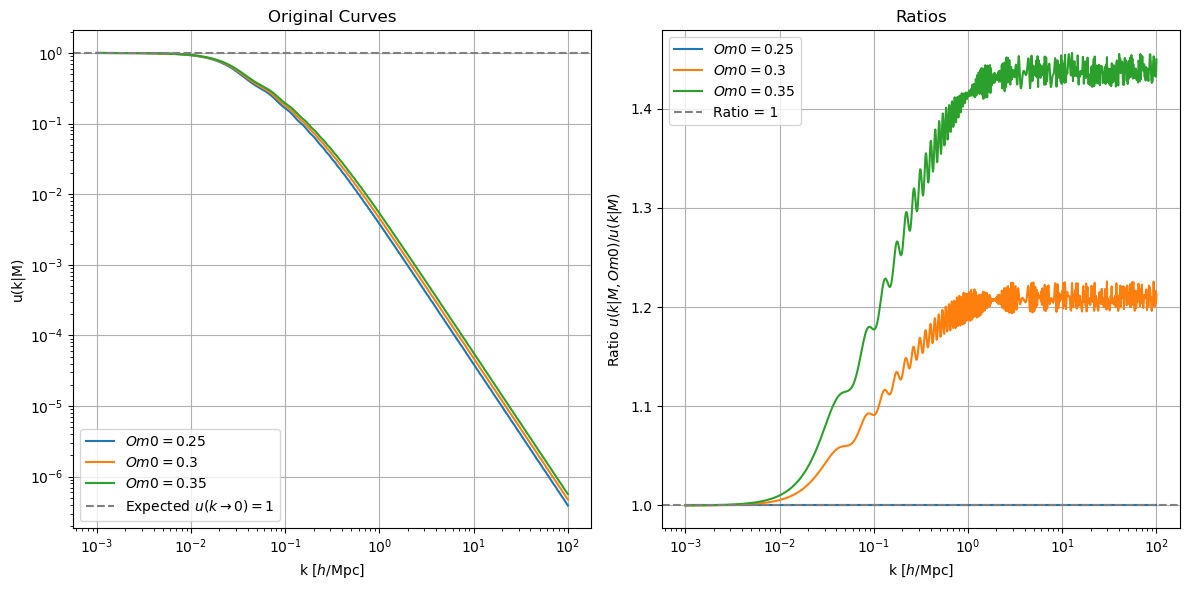

In [51]:
def plot_cosmology_variation(param_name, param_values, mass=3e11, z=0):
    """
    Plots the variation of u(k|M) and its ratio for different values of a cosmological parameter.

    Parameters:
    - param_name: str, the name of the cosmological parameter to vary (e.g., 'ns', 'sigma8').
    - param_values: list, the values of the parameter to test.
    - mass: float, the mass of the halo (default: 1e12 Msun/h).
    - z: float, the redshift (default: 0).
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    uk = None

    for param_value in param_values:
        # Update cosmology with the new parameter value
        new_cosmology = cosmology.setCosmology('planck15', {param_name: param_value})
        
        if uk is None:
            # Compute uk for the first parameter value
            k, uk = compute_analytic_uk(mass=mass, z=z)
            k_new, uk_new = k, uk
        else:
            # Recompute u(k) with the updated cosmology
            k_new, uk_new = compute_analytic_uk(mass=mass, z=z)

        # Plot the updated u(k) on axis 0
        ax[0].loglog(k_new, np.abs(uk_new), label=f'${param_name}={param_value}$')

        # Interpolate uk_new to match the k values of uk
        interp_uk_new = interp1d(k_new, np.abs(uk_new), kind='linear', bounds_error=False, fill_value="extrapolate")
        uk_new_interp = interp_uk_new(k)

        # Plot the ratio on axis 1
        ratio = uk_new_interp / np.abs(uk)
        ax[1].semilogx(k, ratio, label=f'${param_name}={param_value}$')

    # Customize axis 0
    ax[0].axhline(1, ls='--', color='gray', label='Expected $u(k\\to0)=1$')
    ax[0].set_xlabel("k [$h$/Mpc]")
    ax[0].set_ylabel("u(k|M)")
    ax[0].grid(True)
    ax[0].legend()
    ax[0].set_title("Original Curves")

    # Customize axis 1
    ax[1].axhline(1, ls='--', color='gray', label='Ratio = 1')
    ax[1].set_xlabel("k [$h$/Mpc]")
    ax[1].set_ylabel(f"Ratio $u(k|M, {param_name}) / u(k|M)$")
    ax[1].grid(True)
    ax[1].legend()
    ax[1].set_title("Ratios")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_cosmology_variation('ns', [0.95, 0.97, 1.0])
plot_cosmology_variation('sigma8', [0.7, 0.8, 0.9])
plot_cosmology_variation('H0', [67.0, 70.0, 73.0])
plot_cosmology_variation('Om0', [0.25, 0.3, 0.35])